# <center> CIFAR-10
by Hyr1sky_He

~~老朋友了，上次拿ResNet写的，这次试试MLP~~

## 1. 数据处理

### 1.1 读入数据

In [40]:
import numpy as np
import pandas as pd
import time
import torch
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

# Constants
IMAGE_SIZE = 32
NUM_CLASSES = 10
COLOR_CHANNELS = 3

In [41]:
cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, '\nCUDA:', cuda)

Using PyTorch version: 2.0.1 
CUDA: True


将二维图像通过transform转换成可输入MLP的张量把它直接加载进来

In [42]:
# transform
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize(40),
    torchvision.transforms.RandomResizedCrop(32,scale=(0.64,1.0),ratio=(1.0,1.0)), # 裁剪
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914,0.4822,0.4465],
                                   [0.2023,0.1994,0.2010])
]) # 对RGB三通道标准化

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914,0.4822,0.4465],
                                    [0.2023,0.1994,0.2010])
])

In [43]:
# Load the dataset
cifar10 = torchvision.datasets.CIFAR10(root='../Assignment1_dataset/', 
                                       transform = transform_train,
                                       train = True, 
                                       download = False)
cifar10_test = torchvision.datasets.CIFAR10(root='../Assignment1_dataset/', 
                                            transform = transform_test,
                                            train = False, 
                                            download = False)

### 1.2 观察数据

虽然说CIFAR-10的数据是辛顿老爷子他们收集的，总共十类，并且不存在什么错误数据的，但还是可以看一下有个直观的感受。\
把Batch_1和meta先读进来，看看Label

In [44]:
data_batch_1 = pd.read_pickle('../Assignment1_dataset/cifar-10-batches-py/data_batch_1')
meta = pd.read_pickle('../Assignment1_dataset/cifar-10-batches-py/batches.meta')
test_batch = pd.read_pickle('../Assignment1_dataset/cifar-10-batches-py/test_batch')

print(data_batch_1.keys())
print(meta.keys())

dict_keys(['batch_label', 'labels', 'data', 'filenames'])
dict_keys(['num_cases_per_batch', 'label_names', 'num_vis'])


meta包含了数据集的各种label和信息，再细看一下，顺便把batch_1独热编码了。

In [45]:
one_hot_labels = set(data_batch_1['labels'])
print(one_hot_labels)
label_names = meta['label_names']
print(label_names, '\n')
label_dict = dict(zip(one_hot_labels, label_names))
print('字典')
for i in range(10):
    print(i, ':', label_dict[i])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] 

字典
0 : airplane
1 : automobile
2 : bird
3 : cat
4 : deer
5 : dog
6 : frog
7 : horse
8 : ship
9 : truck


In [46]:
train_data_1 = list(data_batch_1['labels'])
test_data = list(test_batch['labels'])
print('train_data:', len(train_data_1))
print('test_data:', len(test_data))

train_data: 10000
test_data: 10000


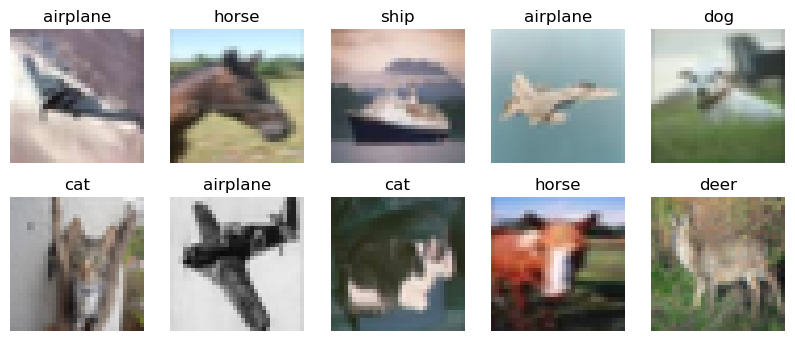

In [47]:
# 随机打印10张图片
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(train_data_1))
        img = data_batch_1['data'][idx]
        label = data_batch_1['labels'][idx]
        ax[i][j].imshow(img.reshape(3, 32, 32).transpose(1, 2, 0))
        ax[i][j].set_title(label_dict[label])
        ax[i][j].axis('off')

### 1.3 数据装载

把五个batch都装载进来，准备进行MLP训练

In [48]:
# 数据加载
"""
data_batch_2 = pd.read_pickle('../Assignment1_dataset/cifar-10-batches-py/data_batch_2')
data_batch_3 = pd.read_pickle('../Assignment1_dataset/cifar-10-batches-py/data_batch_3')
data_batch_4 = pd.read_pickle('../Assignment1_dataset/cifar-10-batches-py/data_batch_4')
data_batch_5 = pd.read_pickle('../Assignment1_dataset/cifar-10-batches-py/data_batch_5')

train_data_2 = list(data_batch_2['labels'])
train_data_3 = list(data_batch_3['labels'])
train_data_4 = list(data_batch_4['labels'])
train_data_5 = list(data_batch_5['labels'])

train_data = train_data_1 + train_data_2 + train_data_3 + train_data_4 + train_data_5
train_data = list(train_data)
test_data = list(test_data)

print('train_data:', len(train_data))
print('test_data:', len(test_data))
"""

"\ndata_batch_2 = pd.read_pickle('../Assignment1_dataset/cifar-10-batches-py/data_batch_2')\ndata_batch_3 = pd.read_pickle('../Assignment1_dataset/cifar-10-batches-py/data_batch_3')\ndata_batch_4 = pd.read_pickle('../Assignment1_dataset/cifar-10-batches-py/data_batch_4')\ndata_batch_5 = pd.read_pickle('../Assignment1_dataset/cifar-10-batches-py/data_batch_5')\n\ntrain_data_2 = list(data_batch_2['labels'])\ntrain_data_3 = list(data_batch_3['labels'])\ntrain_data_4 = list(data_batch_4['labels'])\ntrain_data_5 = list(data_batch_5['labels'])\n\ntrain_data = train_data_1 + train_data_2 + train_data_3 + train_data_4 + train_data_5\ntrain_data = list(train_data)\ntest_data = list(test_data)\n\nprint('train_data:', len(train_data))\nprint('test_data:', len(test_data))\n"

In [49]:
# DataLoader 并把二维图像转换为一维向量

Batch_Size = 64
"""
train_loader = DataLoader(TensorDataset(torch.tensor(train_data), 
                                        torch.tensor(train_data)), 
                                        batch_size=Batch_Size, 
                                        shuffle=True)
test_loader = DataLoader(TensorDataset(torch.tensor(test_data),
                                        torch.tensor(test_data)), 
                                        batch_size=Batch_Size, 
                                        shuffle=True)
"""
train_loader = DataLoader(cifar10, batch_size=Batch_Size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=Batch_Size, shuffle=True)

**将`batch_size`定为64，存入后查看每个batch的shape**

In [50]:
Data_Sample = list(train_loader)
image_sample, labels_sample = Data_Sample[0]
print('image_sample:', image_sample.shape)
print('labels_sample:', labels_sample.shape)

image_sample: torch.Size([64, 3, 32, 32])
labels_sample: torch.Size([64])


## 2. 构建模型
引入MLP对数据进行训练

### 2.1 搭建MLP
利用Pytorch框架搭建 MLP，input_size, hidden_size, num_classes分别为网络输入/隐藏层/输出层神经元个数

In [119]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()

        h1, h2, h3 = hidden_size
        self.linear1 = torch.nn.Linear(input_size, h1) # 输入层到第一层隐藏层的线性变换
        self.relu1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(h1, h2) # 第一层隐藏层到第二层隐藏层的线性变换
        self.relu2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(h2, h3) # 第二层隐藏层到第三层隐藏层的线性变换
        self.relu3 = torch.nn.ReLU()
        self.linear4 = torch.nn.Linear(h2, num_classes) # 第四层隐藏层到输出层的线性变换
        self.dropout = torch.nn.Dropout(0.25)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        out = self.linear1(x)
        out = self.relu1(out)
        # out = self.dropout(out)
        out = self.linear2(out)
        out = self.relu2(out)
        # out = self.dropout(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.dropout(out)
        out = self.linear4(out)
        # out = self.softmax(out)
        return out

### 2.2 模型训练
- 设定优化器，采用Adam算法更新梯度
- 设定损失函数，分类问题可以通过交叉熵损失函数计算loss
- 设定超参数（迭代次数Epoch、批次大小batchsize、学习率lr）
- 获取数据和标签
- 将输入数据展平为一维向量
- 计算输出
- 梯度清零后计算损失函数
- 反向传播计算梯度
- 使用优化器更新模型参数
- 将每个批次的损失值累加用于计算平均损失
- 计算每个批次正确分类的图像数量

关于Adam和L2正则化，误区[分析](https://arxiv.org/abs/1711.05101)

In [120]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('./runs/MLP')
def train(model):
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    epochs = 10
    for epoch in range(epochs):
        sum_loss = 0.0
        train_correct = 0
        start_time = time.time()
        for data in train_loader:
            inputs, labels = data
            if cuda:
                inputs, labels = inputs.cuda(), labels.cuda()
            inputs = inputs.view(inputs.size(0), -1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            # 将predicated保存

        end_time = time.time()
        execution_time = end_time - start_time

        avg_loss = sum_loss / (len(cifar10))
        avg_acc = 100.0 * train_correct / (len(cifar10))
        writer.add_scalar('Loss/train', avg_loss, epoch)
        writer.add_scalar('Acc/train', avg_acc, epoch)

        print('Epoch: {} Loss: {:.6f} Acc: {:.6f} Time: {:.3f}'\
              .format(epoch + 1, avg_loss, avg_acc, execution_time))
    
    print('Finished Training')
    writer.close()

In [116]:
# 正式训练
input_size = IMAGE_SIZE * IMAGE_SIZE * COLOR_CHANNELS
hidden_size = [512, 256, 128]
num_classes = 10

model = MLP(input_size, hidden_size, num_classes)
if cuda:
    model = model.cuda()
train(model)

# 保存模型
torch.save(model.state_dict(), './model/MLP.pth')

Epoch: 1 Loss: 0.028796 Acc: 34.052000 Time: 19.626
Epoch: 2 Loss: 0.026602 Acc: 39.570000 Time: 21.590
Epoch: 3 Loss: 0.025715 Acc: 41.424000 Time: 22.535
Epoch: 4 Loss: 0.025149 Acc: 42.586000 Time: 21.720
Epoch: 5 Loss: 0.024783 Acc: 43.396000 Time: 21.260
Epoch: 6 Loss: 0.024445 Acc: 44.294000 Time: 24.034
Epoch: 7 Loss: 0.024182 Acc: 44.664000 Time: 23.216
Epoch: 8 Loss: 0.024023 Acc: 45.200000 Time: 23.682
Epoch: 9 Loss: 0.023825 Acc: 45.744000 Time: 21.681
Epoch: 10 Loss: 0.023599 Acc: 46.158000 Time: 22.560
Finished Training


In [100]:
from tensorboard import notebook
notebook.display(port=6006, height=1000)
%tensorboard --logdir ./runs/MLP

Selecting TensorBoard with logdir ./runs/MLP (started 17:39:47 ago; port 6006, pid 31836).


UsageError: Line magic function `%tensorboard` not found.


### 2.3 模型测试
- 获取数据和标签
- 展平数据输入到网络
- 加载训练好的模型
- 获得输出

In [117]:
def test(model, test_loader):
    model.eval()
    test_correct = 0
    start_time = time.time()

    for data in test_loader:
        inputs, labels = data
        if cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        inputs = inputs.view(inputs.size(0), -1)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
    
    sorted_id = list(range(1, len(cifar10_test) + 1))
    sorted_id.sort(key=lambda x: str(x))
    end_time = time.time()
    execution_time = end_time - start_time
    print('Test Acc: {:.6f} Time: {:.3f}'.format(100.0 * test_correct / (len(cifar10_test)), execution_time))
    # 打印
    """
    df = pd.DataFrame({'id': sorted_id, 'label': predicted.tolist()})
    df['label'] = df['label'].apply(lambda x: label_dict[x])
    df.to_csv('submission.csv',index=False)
    """

In [118]:
# 测试
test(model, test_loader)
# 输出预测结果
for X in test_loader:
    inputs, labels = X
    if cuda:
        inputs, labels = inputs.cuda(), labels.cuda()
    inputs = inputs.view(inputs.size(0), -1)
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    # 输出图片
    print('预测结果：')
    print(predicted)
    print('真实结果：')
    print(labels)
    break

Test Acc: 48.510000 Time: 1.667
预测结果：
tensor([0, 0, 8, 5, 0, 8, 1, 7, 7, 3, 5, 2, 9, 7, 2, 6, 0, 0, 0, 6, 2, 5, 4, 7,
        4, 4, 9, 7, 6, 2, 4, 4, 7, 7, 3, 8, 6, 0, 2, 1, 8, 7, 3, 3, 8, 0, 0, 7,
        3, 9, 0, 5, 4, 3, 7, 8, 1, 3, 6, 8, 0, 4, 0, 7], device='cuda:0')
真实结果：
tensor([0, 0, 8, 3, 0, 7, 8, 2, 7, 3, 0, 2, 1, 7, 5, 6, 8, 8, 0, 6, 2, 3, 4, 7,
        6, 7, 3, 9, 7, 8, 3, 4, 5, 7, 3, 1, 7, 2, 2, 8, 0, 7, 7, 4, 0, 0, 5, 7,
        5, 0, 0, 5, 4, 5, 2, 8, 1, 2, 2, 8, 0, 2, 8, 7], device='cuda:0')


**结果记录：**

<font color = "red"> **Acc = 22.55** </font>
<font color = "orange"> **有dropout 有softmax batch_size = 64 四层MLP epochs = 10 lr = 0.001** </font>
```text
Test Acc: 22.550000 Time: 1.892
预测结果：
tensor([0, 0, 6, 7, 1, 6, 7, 7, 6, 1, 6, 0, 0, 0, 0, 6, 0, 1, 0, 7, 1, 6, 0, 1,
        0, 0, 6, 6, 7, 0, 7, 6, 6, 1, 6, 0, 6, 1, 7, 0, 6, 6, 0, 6, 6, 7, 1, 1,
        1, 1, 6, 6, 0, 1, 1, 7, 1, 1, 0, 0, 1, 6, 6, 1], device='cuda:0')
真实结果：
tensor([3, 0, 3, 3, 3, 6, 6, 0, 5, 2, 6, 0, 0, 2, 2, 7, 8, 4, 9, 5, 7, 6, 8, 9,
        0, 8, 6, 3, 3, 5, 5, 2, 1, 0, 4, 2, 2, 0, 5, 2, 7, 4, 8, 3, 3, 5, 0, 9,
        4, 8, 5, 4, 9, 7, 3, 5, 8, 3, 8, 0, 0, 9, 3, 5], device='cuda:0')
```

<font color = "red"> **Acc = 23.00** </font>
<font color = "orange"> **有dropout 有softmax batch_size = 64 三层MLP epochs = 50 lr = 0.001** </font>
```text
Test Acc: 23.000000 Time: 1.719
预测结果：
tensor([9, 9, 8, 7, 8, 7, 8, 0, 7, 7, 5, 8, 8, 8, 0, 7, 7, 7, 5, 8, 8, 7, 9, 5,
        5, 8, 5, 1, 9, 5, 1, 5, 5, 8, 8, 9, 8, 7, 8, 7, 1, 1, 7, 1, 8, 5, 7, 7,
        9, 5, 1, 7, 8, 8, 7, 9, 7, 8, 9, 8, 7, 1, 7, 1], device='cuda:0')
真实结果：
tensor([0, 3, 8, 0, 4, 4, 5, 8, 6, 7, 5, 8, 8, 8, 0, 6, 2, 9, 7, 0, 8, 4, 4, 2,
        5, 2, 5, 8, 0, 2, 1, 8, 5, 2, 8, 3, 8, 2, 0, 2, 2, 1, 4, 3, 5, 3, 2, 3,
        7, 5, 1, 3, 7, 0, 6, 1, 2, 9, 7, 1, 4, 9, 5, 3], device='cuda:0')
```

<font color = "red"> **Acc = 48.51** </font>
<font color = "orange"> **激活函数Sigmoid 有dropout 有softmax batch_size = 64 三层MLP epochs = 10 lr = 0.001** </font>
```text
Test Acc: 48.510000 Time: 1.667
预测结果：
tensor([0, 0, 8, 5, 0, 8, 1, 7, 7, 3, 5, 2, 9, 7, 2, 6, 0, 0, 0, 6, 2, 5, 4, 7,
        4, 4, 9, 7, 6, 2, 4, 4, 7, 7, 3, 8, 6, 0, 2, 1, 8, 7, 3, 3, 8, 0, 0, 7,
        3, 9, 0, 5, 4, 3, 7, 8, 1, 3, 6, 8, 0, 4, 0, 7], device='cuda:0')
真实结果：
tensor([0, 0, 8, 3, 0, 7, 8, 2, 7, 3, 0, 2, 1, 7, 5, 6, 8, 8, 0, 6, 2, 3, 4, 7,
        6, 7, 3, 9, 7, 8, 3, 4, 5, 7, 3, 1, 7, 2, 2, 8, 0, 7, 7, 4, 0, 0, 5, 7,
        5, 0, 0, 5, 4, 5, 2, 8, 1, 2, 2, 8, 0, 2, 8, 7], device='cuda:0')
```

<font color = "red"> **Acc = 52.08** </font>
<font color = "orange"> **有dropout 无softmax batch_size = 64 四层MLP epochs = 10 lr = 0.001** </font>
```text
Test Acc: 52.080000 Time: 1.852
预测结果：
tensor([7, 7, 6, 2, 4, 8, 9, 9, 1, 1, 3, 6, 0, 0, 1, 4, 8, 2, 7, 5, 8, 8, 7, 7,
        6, 4, 2, 8, 8, 2, 2, 9, 8, 1, 7, 9, 5, 5, 5, 6, 5, 8, 1, 4, 5, 0, 8, 3,
        0, 2, 5, 0, 4, 5, 4, 5, 9, 8, 0, 6, 4, 9, 1, 1], device='cuda:0')
真实结果：
tensor([4, 7, 8, 2, 4, 8, 9, 1, 1, 1, 3, 1, 0, 0, 1, 3, 8, 2, 5, 3, 5, 8, 7, 7,
        6, 2, 2, 8, 8, 0, 6, 3, 8, 1, 5, 3, 0, 5, 6, 6, 4, 8, 1, 4, 7, 4, 2, 3,
        0, 6, 5, 0, 4, 3, 2, 3, 1, 0, 7, 6, 4, 1, 1, 1], device='cuda:0')
```

<font color = "red"> **Acc = 54.21** </font>
<font color = "orange"> **无dropout 无softmax batch_size = 64 四层MLP epochs = 10 lr = 0.001** </font>
```text
Test Acc: 54.210000 Time: 2.260
预测结果：
tensor([7, 6, 7, 8, 5, 7, 5, 7, 1, 7, 3, 2, 1, 3, 4, 9, 6, 4, 9, 1, 6, 5, 0, 1,
        1, 6, 8, 9, 2, 6, 7, 2, 6, 9, 5, 0, 6, 2, 6, 6, 1, 7, 7, 8, 5, 1, 7, 3,
        1, 3, 9, 1, 6, 7, 8, 0, 0, 0, 8, 2, 1, 1, 6, 6], device='cuda:0')
真实结果：
tensor([4, 6, 7, 2, 3, 7, 5, 7, 1, 7, 6, 0, 1, 3, 3, 8, 5, 7, 9, 9, 2, 7, 4, 1,
        1, 3, 8, 1, 6, 9, 7, 2, 3, 9, 5, 0, 6, 2, 6, 6, 1, 7, 7, 8, 5, 8, 6, 7,
        1, 6, 9, 1, 2, 7, 0, 0, 2, 1, 8, 7, 1, 1, 2, 6], device='cuda:0')
```

<font color = "red"> **Acc = 59.55** </font>
<font color = "orange"> **无dropout 无softmax batch_size = 64 四层MLP epochs = 100 lr = 0.001** </font>
```text
Test Acc: 59.550000 Time: 2.293
预测结果：
tensor([5, 2, 5, 4, 2, 6, 9, 8, 6, 6, 0, 9, 8, 7, 3, 9, 7, 9, 4, 4, 0, 8, 2, 6,
        7, 9, 5, 7, 8, 9, 8, 9, 4, 8, 2, 8, 7, 5, 9, 0, 0, 4, 8, 4, 0, 7, 4, 3,
        1, 2, 9, 2, 2, 4, 2, 7, 0, 3, 9, 8, 9, 1, 5, 0], device='cuda:0')
真实结果：
tensor([5, 2, 8, 7, 5, 6, 9, 0, 4, 9, 8, 6, 8, 7, 5, 9, 7, 1, 5, 4, 0, 8, 2, 6,
        5, 9, 8, 7, 8, 2, 9, 9, 7, 8, 4, 8, 7, 5, 6, 0, 0, 4, 8, 4, 7, 7, 2, 4,
        8, 2, 9, 4, 0, 4, 2, 7, 0, 4, 9, 9, 9, 8, 2, 0], device='cuda:0')
```

### 2.4 绘制混淆矩阵

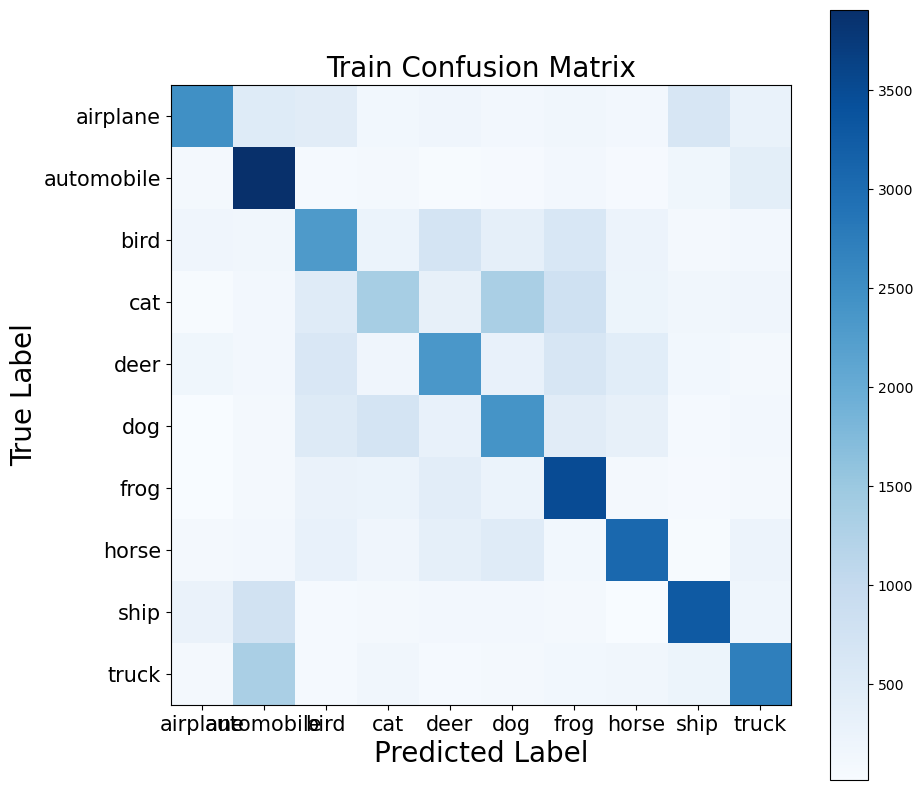

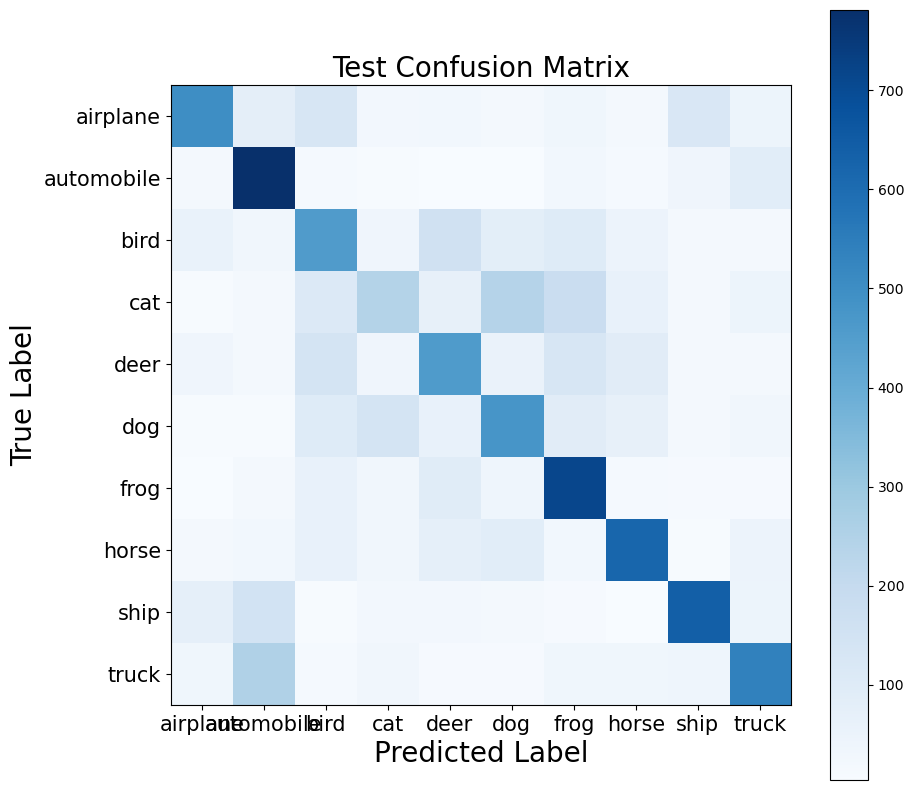

In [94]:
# 可视化在训练数据和测试数据上的混淆矩阵
train_confusion_matrix = torch.zeros(NUM_CLASSES, NUM_CLASSES)
test_confusion_matrix = torch.zeros(NUM_CLASSES, NUM_CLASSES)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)
    plt.show()

def get_confusion_matrix(model, loader, confusion_matrix):
    model.eval()
    for data in loader:
        inputs, labels = data
        if cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        inputs = inputs.view(inputs.size(0), -1)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(labels)):
            confusion_matrix[labels[i], predicted[i]] += 1
    return confusion_matrix

train_confusion_matrix = get_confusion_matrix(model, train_loader, train_confusion_matrix)
test_confusion_matrix = get_confusion_matrix(model, test_loader, test_confusion_matrix)

plot_confusion_matrix(train_confusion_matrix.numpy(), label_names, title='Train Confusion Matrix')
plot_confusion_matrix(test_confusion_matrix.numpy(), label_names, title='Test Confusion Matrix')

In [97]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

train_confusion_matrix = confusion_matrix(, cifar10)
test_confusion_matrix = confusion_matrix(, cifar10_test)
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.heatmap(train_confusion_matrix, square = True, annot=True, fmt='d', 
            cbar = False, cmap = "YlGnBu")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Train Confusion Matrix')
plt.subplot(122)
sns.heatmap(test_confusion_matrix, square = True, annot=True, fmt='d', 
            cbar = False, cmap = "YlGnBu")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [10, 50000]